# Analysis of UQ runs - Evaluating Optimised Prediction
I took the predicted optimum value from the runs using uniform distributions and evaluated it. 
I wanted to see test the following:
* If this value does increase convergence and if so by how much.
* What is the relationship between my estimated probability 
* If the predictions about how iteration values would change came true.
* If I run an inputfile once through, does it match the predictions?


## Run information

- baseline 2018
- pnetel is 400.
- Fixed rmajor to 9.0, the average of a previous uq run.
- Maximise Net Electric
- pheat turned on
- UQ bounds are +/- 20%.

## Import the Uncertainty Data and create object

## Calculate Sensitivity Indices and Reliability

In [1]:
# %load_ext autoreload
# %autoreload 1
from pathlib import Path
import sys
sys.path.append('/home/graeme/process_uq/')
sys.path.append('/home/graeme/PROCESS_SALib/')
from uq_analysis import UncertaintyData, Copula, InteractivePlot
# from bokeh.plotting import figure 
from bokeh.io import output_notebook
output_notebook()

proj_dir = str(Path.cwd())+"/"
proj_dir = "/home/graeme/data/uq_run_data/uq_tool_analysis/flat_dist_runs_optimised/"
figure_of_merit = "powfmw"
uq_data = UncertaintyData(proj_dir, figure_of_merit)
uq_data.calculate_sensitivity(figure_of_merit)
uq_data.calculate_reliability()
# print("rmajor mean: ", round(uq_data.converged_df["rmajor"].mean(),2))
print("Number of samples: ", len(uq_data.uncertainties_df))
print(
    "Number of converged runs: ",
    uq_data.number_of_converged_runs,
)
print("Reliability: ", uq_data.reliability_index)



Loading BokehJS ...

Number of samples:  15403
Number of converged runs:  8562
Reliability:  0.56


# Convergence rate
* The convergence rate is higher.

## Regional Sensitivity - what causes PROCESS to converge?

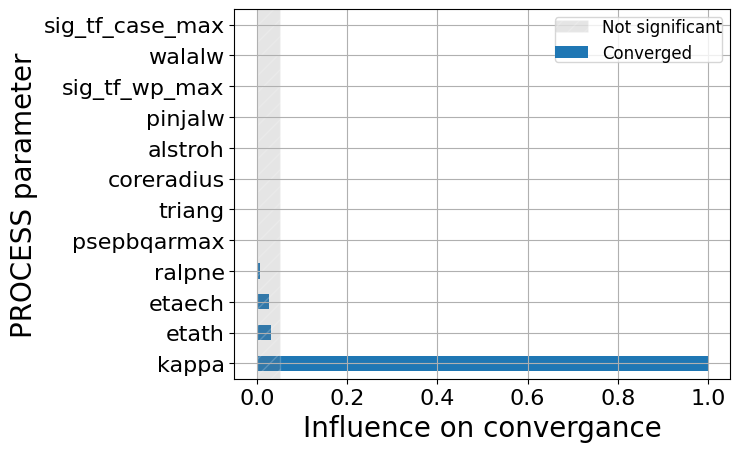

['kappa']


In [2]:
uq_data.convergence_regional_sensitivity_analysis(uq_data.input_names)
uq_data.plot_sumsq_sensitivity()
significant_conv_vars = uq_data.find_significant_parameters(uq_data.sumsq_sensitivity_df,"unconverged",0.1).tolist()
print(significant_conv_vars)

## Find the iteration variables which are influential for the significant convergence variables

These iteration values drive performance recovery: ['betalim', 'vtfskv', 'vdalw', 'cohbop', 'oh_steel_frac', 'tmargoh', 'tmargtf', 'bt', 'cpttf', 'gapds', 'tfcth', 'gapoh', 'jwptf', 'thwcndut', 'ohcth', 'tdmptf']


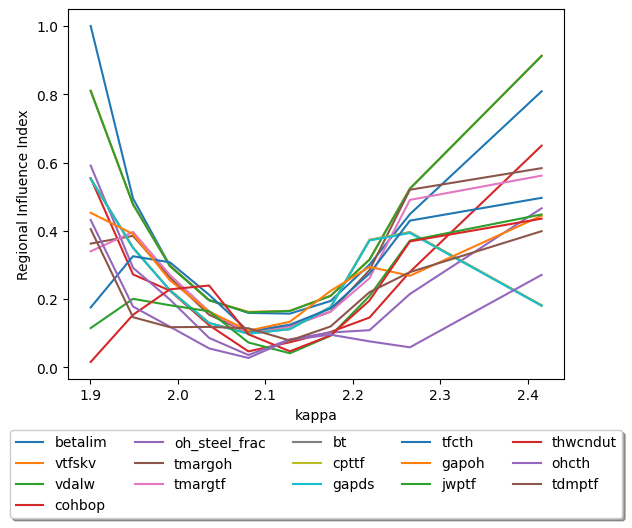

In [3]:
rsa_variables = uq_data.itv
significant_itv_list = []
for item in significant_conv_vars:
    rsa_df = uq_data.regional_sensitivity_analysis(figure_of_merit=item,variables_to_sample=rsa_variables, dataframe=uq_data.converged_df, bins=10, confidence_level = 0.4)
    significant_itv_list.extend(rsa_df.index.tolist())
significant_itv_list = list(dict.fromkeys(significant_itv_list))
print("These iteration values drive performance recovery:", significant_itv_list)

## Create a copula based on the important variables for convergence and iteration variables

In [4]:
copula = Copula(uq_data.converged_df, significant_conv_vars)
copula.calculate_copula(input_sample_size=500,synthetic_sample_size=100000)
copula.calculate_pdf()
pdf_df=copula.create_pdf_df()
copula.find_max_pdf(print_data=False)


/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)


kappa    2.063713
pdf      0.398942
Name: 30611, dtype: float64

In [5]:
itv_vars = significant_conv_vars + significant_itv_list
print(significant_itv_list)
itv_copula = Copula(uq_data.converged_df,itv_vars)
itv_copula.calculate_copula(input_sample_size=500,synthetic_sample_size=100000)
itv_copula.calculate_pdf()
itv_pdf_df=itv_copula.create_pdf_df()



['betalim', 'vtfskv', 'vdalw', 'cohbop', 'oh_steel_frac', 'tmargoh', 'tmargtf', 'bt', 'cpttf', 'gapds', 'tfcth', 'gapoh', 'jwptf', 'thwcndut', 'ohcth', 'tdmptf']


/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  a = (self.min - loc) / scale
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in scalar d

In [6]:
custom_point={"kappa":2.0,"etath":0.35,"etaech":0.35}
sens_plots=InteractivePlot(uq_data,copula,num_intervals=20,custom_data_point=custom_point)
sens_plots.create_layout(significant_conv_vars)

In [7]:
custom_point={"kappa":1.8}
itv_plots=InteractivePlot(uq_data,itv_copula,num_intervals=20,custom_data_point=custom_point)
itv_plots.create_layout(itv_vars,plot_graph=False)